# Модель прогнозирования оттока пользователей JustKids

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Нажмите, чтобы показать/скрыть код"></form>''')

In [2]:
import pandas as pd
import numpy as np

#библиотеки для визулизации
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#библиотеки машинного обучения
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils import resample

pd.set_option('display.max_columns', 30)

# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

In [3]:
df = pd.read_csv('Students_churn_matrix_2020_10_15.csv')

Для построения модели были использованы данные по студентам с учетом следующих условий:
1. Дата первой активности студента не должна быть позже, чем 8 недель назад от текущей даты. Это позволяет учесть только тех студентов, которые "прожили" 0-3 неделю, для которых мы рассчитывали показатели и после этого прошли еще 4 недели, по которым мы определяем отток  


2. Дата первой активности равна дате первого урока студента при условии, что у этого урока указан id (pl.id is not null), урок не является пробным уроком (pl.type != 'trial'), урок имеет статус 2 или 4 (pl.status = 2 or pl.status = 4)  


3. Дата последней активности определяется исходя из тех же условий, что и дата первой активности  


4. Выборка исключает тех студентов, у которых на балансе -1 урок (lc.counter != -1)  

**В данной модели под "оттоком" понимается отсутствие активности у пользователя (прохождение платных уроков) в течение 4х недель.**

## 1. Изучение данных и предобработка

Посмотрим на данные:

In [4]:
df.head()

,id,first_activity,last_activity,age,gender,language_level,utm_source,utm_medium,is_trial,is_trial_completed,new,completed,declined,student_skipped,teacher_skipped,canceled,changes,is_lead_successful,amount_paid,payments,promocode,is_churn
0,13577,2020-03-03,2020-06-18,13,1,4,fb,fb,0,0,0,10,0,0,0,0,1,1,0.0,0,none,1
1,13355,2020-02-29,2020-10-06,14,2,5,fb,none,0,0,0,9,0,1,0,0,2,1,1880.0,1,none,0
2,13120,2020-03-07,2020-09-30,15,1,6,fb,fb,0,0,0,10,0,0,0,0,0,1,2520.0,1,none,0
3,13215,2020-03-12,2020-04-29,8,2,3,fb,fb,0,0,0,6,0,0,0,0,0,1,1880.0,1,none,1
4,13212,2020-03-14,2020-05-02,15,2,4,fb,ig,0,0,0,6,0,0,1,0,0,1,1880.0,1,none,1


In [5]:
df['is_churn'].value_counts()

1    3942
0    2296
Name: is_churn, dtype: int64

Проверим типы данных и наличие пропусков:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6238 entries, 0 to 6237
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  6238 non-null   int64  
 1   first_activity      6238 non-null   object 
 2   last_activity       6238 non-null   object 
 3   age                 6238 non-null   int64  
 4   gender              6238 non-null   object 
 5   language_level      6238 non-null   object 
 6   utm_source          6238 non-null   object 
 7   utm_medium          6224 non-null   object 
 8   is_trial            6238 non-null   int64  
 9   is_trial_completed  6238 non-null   int64  
 10  new                 6238 non-null   int64  
 11  completed           6238 non-null   int64  
 12  declined            6238 non-null   int64  
 13  student_skipped     6238 non-null   int64  
 14  teacher_skipped     6238 non-null   int64  
 15  canceled            6238 non-null   int64  
 16  change

Признаки в датасете преимущественно числовые, но есть также и категориальные, которые нам предстоит преобразовать перед тем, как обучать модель.  
Пропуски присутствуют только по признаку utm_medium, 14 пропусков, заменим пропуски на 'none'.

In [7]:
df['utm_medium'] = df['utm_medium'].fillna('none')

Заменим также тип first_activity и last_activity на формат даты и времени:

In [8]:
df['first_activity'] = pd.to_datetime(df['first_activity'], format='%Y-%m-%d')
df['last_activity'] = pd.to_datetime(df['last_activity'], format='%Y-%m-%d')

Проверим на наличие некорректных данных:

In [9]:
df.describe()

,id,age,is_trial,is_trial_completed,new,completed,declined,student_skipped,teacher_skipped,canceled,changes,is_lead_successful,amount_paid,payments,is_churn
count,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000
mean,16292.935236,9.460725,0.457358,0.422892,0.048092,8.841135,0.186117,0.415037,0.016832,0.156781,0.820295,0.593459,1974.025636,0.800417,0.631933
std,8830.965756,3.579686,0.498218,0.494058,0.447603,2.960581,0.479317,0.802480,0.131122,0.457715,1.595425,0.491227,1850.283731,0.615199,0.482318
min,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8799.750000,7.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,16262.000000,9.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1880.000000,1.000000,1.000000
75%,23983.500000,11.000000,1.000000,1.000000,0.000000,10.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2520.000000,1.000000,1.000000
max,31855.000000,155.000000,1.000000,1.000000,12.000000,41.000000,7.000000,10.000000,2.000000,10.000000,26.000000,1.000000,21520.000000,5.000000,1.000000


Можно заметить, что максиальное значение возраста - 155 лет, минимальное - 0 лет. Очевидно, что это некорретные данные. 
Было принято решение не использовать такой признак, как возраст, при построении модели.

#### Обработка дубликатов.

Проверим, что в данных нет дублирования по id студента:

In [10]:
duplicated_ids = df['id'].value_counts().sort_values(ascending = False).reset_index()
duplicated_ids = duplicated_ids.query('id>1')
duplicated_ids_list = duplicated_ids['index'].unique()

In [11]:
len(duplicated_ids_list)

56

Было обнаружено, что в датасете есть студенты, у которых дублируется информация. 
Было выявлено, что это связано:

1. с тем, что некоторые студенты за первые 4 недели оплачивали уроки более 1 раза и для одного раза использовали промокод, для второго - нет. Было принято решение оставить строку с промокодом.


2. со столбцами 'is_lead_successful' и 'is_trial': в некоторых ситуациях id студента один, а id лидов для этого студента - больше одного. При этом один лид успешно реализован => значение 'is_lead_successful' = 1, а другой - нет, значение 0. Аналогичная ситуация для пробных уроков.

    Какое было принято решение для обработки таких студентов:
    * если у студента есть два разных значения is_lead_successful (0 и 1) => оставляем только 1
    * если у студента есть два разных значения is_trial (0 и 1) => оставляем только 1

**Порядок действий для обработки дубликатов по промокоду:**  
1. Выделим список тех студентов, у которых дублирование связано с промокодами.
2. Очистим датасет от этих студентов.
3. Добавим к датасету этих студентов вновь, но оставим только одну строку для каждого студента, с промокодом

In [12]:
mult_promocode = (df.query('id in @duplicated_ids_list')
                   .groupby('id')
                   .agg({'promocode':'nunique'})
                   .reset_index()
                )
mult_promocode = mult_promocode.query('promocode > 1')
len(mult_promocode)

7

In [13]:
mult_promocode_list = mult_promocode['id'].unique()

In [77]:
print('Количество id студентов c дубликатами по промокоду:', len(df['id'].unique()))
df_wo_duplicates = df.query('id not in @mult_promocode_list')
print('Количество id студентов без дубликатов по промокоду: ',len(df_wo_duplicates['id'].unique()))

Количество id студентов c дубликатами по промокоду: 6181
Количество id студентов без дубликатов по промокоду:  6174


In [15]:
df_mult_promocode_clean = df.query('id in @mult_promocode_list and promocode != "none"')
len(df_mult_promocode_clean)

7

In [16]:
df = pd.concat([df_wo_duplicates,df_mult_promocode_clean])

In [17]:
print('Количество id студентов без дубликатов по промокоду:', len(df['id'].unique()))

Количество id студентов без дубликатов по промокоду: 6181


**Порядок действий для обработки дубликатов по лидам:**  
1. Выделим список тех студентов, у которых дублирование связано с наличием нескольких лидов для 1 студента.
2. Очистим датасет от этих студентов.
3. Добавим к датасету этих студентов вновь, но оставим только одну строку для каждого студента.

In [18]:
duplicated_ids_upd = df['id'].value_counts().sort_values(ascending = False).reset_index()
duplicated_ids_upd = duplicated_ids_upd.query('id>1')
duplicated_ids_upd_list = duplicated_ids_upd['index'].unique()

In [19]:
len(duplicated_ids_upd_list)

49

In [20]:
multiple_leads = (df.query('id in @duplicated_ids_upd_list')
                   .groupby('id')
                   .agg({'is_lead_successful':'nunique','is_trial':'nunique'})
                   .sort_values('is_lead_successful', ascending = False)
                   .reset_index()
       )
multiple_leads.head()

,id,is_lead_successful,is_trial
0,671,2,1
1,25144,2,2
2,18884,2,2
3,936,2,1
4,19621,2,2


In [21]:
print('Количество id студентов без дубликатов по промокоду:', len(df['id'].unique()))
df_wo_duplicates = df.query('id not in @duplicated_ids_upd_list')
print('Количество id студентов без дубликатов по промокоду: ',len(df_wo_duplicates['id'].unique()))

Количество id студентов без дубликатов по промокоду: 6181
Количество id студентов без дубликатов по промокоду:  6132


In [22]:
df_mult_leads_clean = (df.loc[df['id'].isin(duplicated_ids_upd_list)]
                           .groupby(['id', 'first_activity', 'last_activity', 'age', 'gender',
                           'language_level', 'new', 'completed', 'declined', 'student_skipped','teacher_skipped', 
                           'canceled', 'changes','amount_paid', 'payments', 'promocode', 'is_churn'], as_index=False)
                           .agg({'is_lead_successful':'max','is_trial':'max','is_trial_completed':'max','utm_source':'max','utm_medium':'max'})
)
len(df_mult_leads_clean)

49

In [23]:
df = pd.concat([df_wo_duplicates,df_mult_leads_clean])

In [24]:
print('Количество id студентов без дубликатов по промокоду:', len(df['id'].unique()))

Количество id студентов без дубликатов по промокоду: 6181


In [25]:
duplicated_ids = df['id'].value_counts().sort_values(ascending = False).reset_index()
duplicated_ids = duplicated_ids.query('id>1')
print('Количество дубликатов в id студентов после обработки: {}'.format(len(duplicated_ids)))

Количество дубликатов в id студентов после обработки: 0


## 2. Обработка категориальных переменных.

In [26]:
categorical = [var for var in df.columns if df[var].dtype=='O']

print('Всего в датасете {} категориальных переменных\n'.format(len(categorical)))

print('Список категориальных переменных :\n\n', categorical)

Всего в датасете 5 категориальных переменных

Список категориальных переменных :

 ['gender', 'language_level', 'utm_source', 'utm_medium', 'promocode']


#### 1. gender

In [27]:
df['gender'].value_counts()

1       2750
2       2532
none     899
Name: gender, dtype: int64

In [28]:
print('Признак пола отсутствует для {:.2%} пользователей'.format(len(df.query('gender == "none"'))/len(df)))

Признак пола отсутствует для 14.54% пользователей


Заменим пол = 'none' на значение 0 - 'пол не указан'

In [29]:
df['gender'] = df['gender'].replace(to_replace='none',value=0)

In [30]:
df['gender'].value_counts()

1    2750
2    2532
0     899
Name: gender, dtype: int64

#### 2. language_level

In [31]:
df['language_level'].value_counts()

3       1751
4       1660
1       1160
5        748
2        317
6        292
none     246
7          7
Name: language_level, dtype: int64

In [32]:
print('Признак уровня отсутствует для {:.2%} пользователей'.format(len(df.query('language_level == "none"'))/len(df)))

Признак уровня отсутствует для 3.98% пользователей


Заменим уровень языка = 'none' на значение 0 - 'уровень не указан'

In [33]:
df['language_level'] = df['language_level'].replace(to_replace='none',value=0)

In [34]:
df[df['language_level'] == 0]

,id,first_activity,last_activity,age,gender,language_level,utm_source,utm_medium,is_trial,is_trial_completed,new,completed,declined,student_skipped,teacher_skipped,canceled,changes,is_lead_successful,amount_paid,payments,promocode,is_churn
1552,23682,2020-05-18,2020-05-18,7,1,0,none,none,1,0,0,1,0,1,0,0,1,0,0.0,0,none,1
1589,2000,2019-04-17,2019-06-23,6,0,0,fb,none,1,0,0,8,0,1,0,1,0,0,0.0,0,none,1
2245,1241,2019-01-08,2019-09-29,8,0,0,none,none,0,1,0,8,0,2,0,0,9,0,0.0,0,none,1
2588,2480,2019-05-19,2019-09-22,8,0,0,fb,none,0,0,1,8,0,3,0,0,2,1,0.0,0,none,1
2693,49,2018-05-30,2019-05-31,10,0,0,none,none,0,0,0,4,0,2,0,0,0,0,0.0,0,none,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3567,5752,2019-10-09,2019-10-09,12,1,0,none,none,0,0,0,1,0,0,0,0,0,0,0.0,0,none,1
3643,6143,2019-10-17,2019-12-13,6,2,0,none,none,0,0,11,12,1,0,0,3,26,0,0.0,0,none,1
4548,11278,2020-01-21,2020-01-21,20,1,0,none,none,0,0,0,1,0,0,0,0,0,0,0.0,0,none,1
4686,11907,2020-02-03,2020-02-12,12,1,0,none,none,0,0,0,0,0,5,0,0,0,0,0.0,0,none,1


#### 3. utm_source

In [35]:
df['utm_source'].unique()

array(['fb', 'none', 'FB', 'youtube', 'referrals', 'search', 'email',
       'instagram', 'gdn', 'email_campaign', 'Insta', 'UniSender',
       'INSTA', 'basecall', 'test', 'utm_source=basecall', 'blogger',
       'google', 'friendbase', 'discovery', 'chugaister'], dtype=object)

В метках есть много повторов разного написания, преобразуем utm_source с помощью словаря и выведем новый список уникальных названий.

In [36]:
sources_dict = {'fb':['fb','FB'], 
               'instagram':['instagram','Insta','INSTA','intagram'], 
               'youtube':['youtube'],
               'referrals':['referrals'],
               'search':['search'],
               'email':['email'],
               'gdn':['gdn'],
               'email_campaign':['email_campaign'],
               'unisender':['UniSender'],
               'basecall':['basecall','utm_source=basecall'],
               'google':['google'],
               'blogger':['blogger'],
               'test':['test'],
               'friendbase':['friendbase'],
               'discovery':['discovery'],
               'chugaister':['chugaister'],
               'none':['none']
        }

In [37]:
def sources(utm_sources):  
    for source, source_list in sources_dict.items():       
        for i in source_list:
            if i in utm_sources:
                return source

In [38]:
df['utm_source_edit'] = df['utm_source'].apply(sources)

In [39]:
df['utm_source_edit'].unique()

array(['fb', 'none', 'youtube', 'referrals', 'search', 'email',
       'instagram', 'gdn', 'unisender', 'basecall', 'test', 'blogger',
       'google', 'friendbase', 'discovery', 'chugaister'], dtype=object)

In [40]:
df['utm_source_edit'].value_counts()

none          3348
fb            2119
referrals      213
gdn            169
youtube        123
search          66
instagram       36
basecall        34
unisender       33
friendbase      19
blogger         10
email            5
google           2
chugaister       2
discovery        1
test             1
Name: utm_source_edit, dtype: int64

In [41]:
print('Признак метки utm_source отсутствует для {:.2%} пользователей'.format(len(df.query('utm_source_edit == "none"'))/len(df)))

Признак метки utm_source отсутствует для 54.17% пользователей


Более чем для половины пользователей отсутсвует информация о метке utm_source. Это не дает нам использовать данный признак для построения модели.

In [42]:
one_hot = pd.get_dummies(df, columns = ['utm_source_edit'])

In [43]:
one_hot

,id,first_activity,last_activity,age,gender,language_level,utm_source,utm_medium,is_trial,is_trial_completed,new,completed,declined,student_skipped,teacher_skipped,...,utm_source_edit_blogger,utm_source_edit_chugaister,utm_source_edit_discovery,utm_source_edit_email,utm_source_edit_fb,utm_source_edit_friendbase,utm_source_edit_gdn,utm_source_edit_google,utm_source_edit_instagram,utm_source_edit_none,utm_source_edit_referrals,utm_source_edit_search,utm_source_edit_test,utm_source_edit_unisender,utm_source_edit_youtube
0,13577,2020-03-03,2020-06-18,13,1,4,fb,fb,0,0,0,10,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,13355,2020-02-29,2020-10-06,14,2,5,fb,none,0,0,0,9,0,1,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,13120,2020-03-07,2020-09-30,15,1,6,fb,fb,0,0,0,10,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,13215,2020-03-12,2020-04-29,8,2,3,fb,fb,0,0,0,6,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,13212,2020-03-14,2020-05-02,15,2,4,fb,ig,0,0,0,6,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,30190,2020-07-31,2020-09-05,13,1,5,fb,fb,1,1,0,13,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
45,30203,2020-08-04,2020-10-13,11,2,3,referrals,none,1,1,0,8,1,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
46,30604,2020-08-05,2020-08-31,5,2,3,none,none,1,1,0,9,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
47,30785,2020-08-13,2020-09-21,12,2,6,none,none,1,1,1,11,0,2,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


#### 4. utm_medium

In [44]:
df['utm_medium'].unique()

array(['fb', 'none', 'ig', 'cpc', 'blogger', 'email', 'test', 'instagram'],
      dtype=object)

In [45]:
df['utm_medium'].value_counts()

none         3955
fb           1106
ig            634
cpc           386
blogger        52
email          37
instagram      10
test            1
Name: utm_medium, dtype: int64

In [46]:
print('Признак метки utm_medium отсутствует для {:.2%} пользователей'.format(len(df.query('utm_medium == "none"'))/len(df)))

Признак метки utm_medium отсутствует для 63.99% пользователей


Признак отсутствует у более чем 64% пользователей, что не дает нам использовать этот признак для модели.

#### 5. promocode

Для промокодов сделаем следующее преобразование: добавим столбец had_promocode, в котором будет указано значение 0, если студент ни разу не использовал промокод для оплаты или 1, если использовал хотя бы при одной оплате.

In [47]:
df['promocode'].unique()

array(['none', 'NAFFY', 'OSIA', 'LEGKO', 'MCQUINN', 'ABAKUMOVA', 'SAKADO',
       'NOSOK', 'marmazka', 'SUMMER', 'CHUGA', 'KRISTI', 'TSOYLITA',
       'NEZDAYS', 'WELCOME', 'KATYTORONTO', 'MICH', 'BLUSHSUPREME',
       'TATAMI'], dtype=object)

In [48]:
def promo(promocode):
    if promocode == 'none':
        return 0
    else:
        return 1

df['had_promocode'] = df['promocode'].apply(promo)

In [49]:
df['had_promocode'].value_counts()

0    6116
1      65
Name: had_promocode, dtype: int64

Основная доля студентов не использовала промокоды для оплаты.

**Таблица корреляции числовых признаков:**

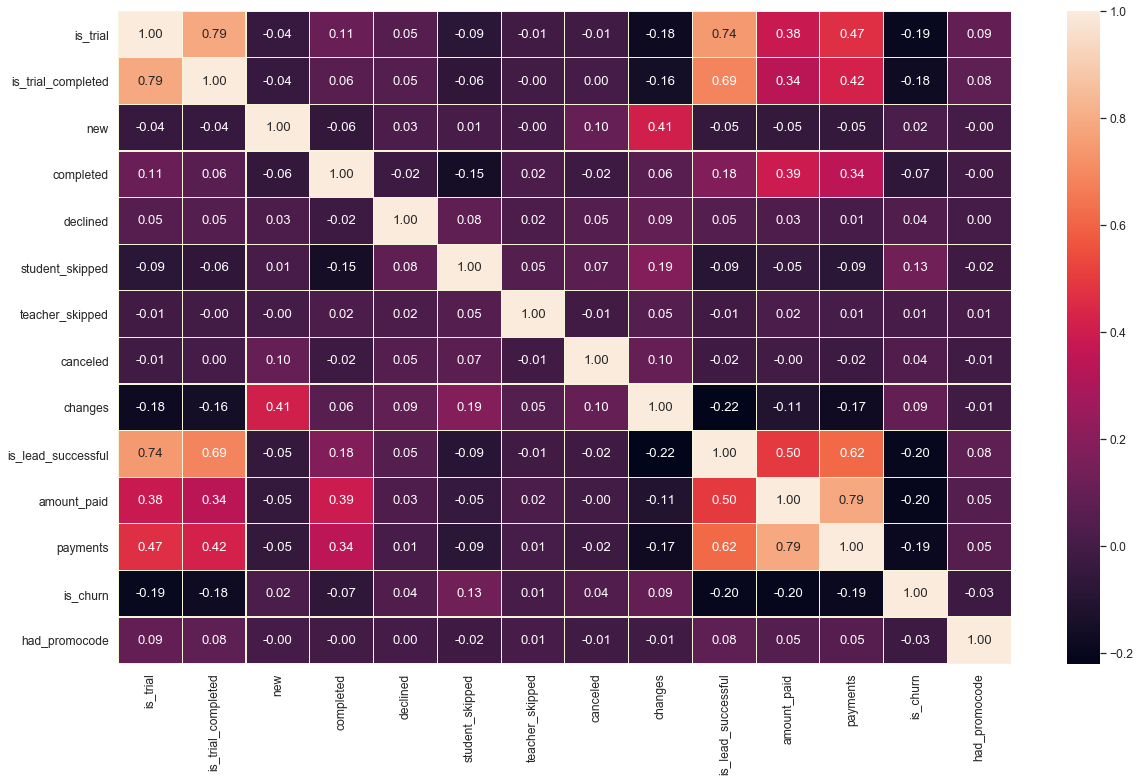

In [50]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=1.1)
sns.heatmap(df.drop(columns=['id','age']).corr(),annot=True,fmt='.2f',linewidths=0.1,linecolor='beige',);

In [51]:
df['is_churn'].value_counts()

1    3918
0    2263
Name: is_churn, dtype: int64

## 4. Построение модели.

In [52]:
y = df['is_churn'] #целевая переменная
X = df.drop(columns=['id','first_activity','last_activity','is_churn','age','utm_source', 'utm_medium','promocode','utm_source_edit']) #признаки

Итак, какие признаки будут использоваться для модели:

1. Метрики количества пройденных уроков по типам уроков: completed, declined, canceled, new, student_skipped, teacher_skipped
2. Уровень языка: language_level
3. Пол студента: gender
4. Выручка от студента за недели 0-3: amount_paid
5. Количество платежей, поступивших от студента за недели 0-3: payments
6. Был ли использован промокод для оплаты: had_promocode
7. Количество замен учителей для студента в недели 0-3: changes
8. Был ли студент приглашен на пробное занятие, когда он был лидом: is_trial
9. Прошел ли студент пробное занятие: is_trial_completed
10. Был ли лид успешным: is_lead_successful


Какие признаки не будем использовать:

1. Идентификатор студента: id
2. Даты первой и последней активности: first_activity и last_activity
3. Возраст: age, поскольку были обнаружены ошибки в данном признаке
4. Utm метки: utm_source (и обработанный столбец utm_source_edit) и utm_medium из-за того, что более чем по половине студентов отсутствует информация
5. Название промокода: promocode, т.к. был создан дополнительный столбец со значениями 0 (без промокода)/1 (с промокодом)

Разделим выборку на обучающую и валидационную:

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

### 4.1. Модель без resampling-а целевой переменной.

In [54]:
#обучаем модель логистической регрессии
model = LogisticRegression(random_state = 0)
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
#воспользуемся обученной моделью на валидационной выборке
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]

In [56]:
#обучаем модель случайного леса
rf_model = RandomForestClassifier(random_state = 0)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [57]:
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]

In [58]:
feature_scores = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

completed             0.260498
language_level        0.178482
amount_paid           0.101947
changes               0.100702
gender                0.070109
student_skipped       0.061135
declined              0.049099
canceled              0.042701
is_trial              0.030545
is_lead_successful    0.026918
is_trial_completed    0.026776
payments              0.024743
new                   0.010708
teacher_skipped       0.008618
had_promocode         0.007019
dtype: float64

In [59]:
data = [['Accuracy',accuracy_score(y_test,predictions),accuracy_score(y_test,rf_predictions)],
        ['Precision',precision_score(y_test,predictions),precision_score(y_test,rf_predictions)],
        ['Recall',recall_score(y_test,predictions),recall_score(y_test,rf_predictions)]]
columns=['Metric','Logistic Regression','Random Forest']

metrics = pd.DataFrame(data = data, columns = columns)

(metrics.style
        .format('{:.2f}', subset=['Logistic Regression','Random Forest'])
        .hide_index()
        .set_caption('Метрики моделей логистической регрессии и случайного леса')
)

Metric,Logistic Regression,Random Forest
Accuracy,0.65,0.62
Precision,0.68,0.68
Recall,0.87,0.77


### 4.2. Модель с downsampling-ом целевой переменной.

Перед обучением модели проведем downsampling целевой переменной, чтобы избежать влияния дисбаланса на результат модели.

In [60]:
training_set = pd.concat([X_train, y_train], axis=1)

churn = training_set[training_set['is_churn'] == 1]
not_churn = training_set[training_set['is_churn'] == 0]

In [61]:
# Undersampling the majority
churn_downsampled = resample(churn, 
                       replace=False, 
                       n_samples=len(not_churn),
                       random_state=42)

# Returning to new training set
downsampled_train = pd.concat([not_churn, churn_downsampled])
downsampled_train['is_churn'].value_counts()

1    1809
0    1809
Name: is_churn, dtype: int64

In [62]:
# Separate undersampled data into X and y sets
downsampled_X_train = downsampled_train.drop('is_churn', axis=1)
downsampled_y_train = downsampled_train['is_churn']

In [63]:
#обучаем модель логистической регрессии
model = LogisticRegression(random_state = 0)
model.fit(downsampled_X_train,downsampled_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
#воспользуемся обученной моделью на валидационной выборке
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]

In [65]:
#обучаем модель случайного леса
rf_model = RandomForestClassifier(random_state = 0)
rf_model.fit(downsampled_X_train, downsampled_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [66]:
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]

In [67]:
feature_scores = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

completed             0.261191
language_level        0.187099
changes               0.096691
amount_paid           0.096455
gender                0.068231
student_skipped       0.063237
declined              0.048406
canceled              0.039453
is_trial              0.034343
is_trial_completed    0.027915
is_lead_successful    0.025740
payments              0.024562
new                   0.011950
teacher_skipped       0.008370
had_promocode         0.006358
dtype: float64

In [68]:
data = [['Accuracy',accuracy_score(y_test,predictions),accuracy_score(y_test,rf_predictions)],
        ['Precision',precision_score(y_test,predictions),precision_score(y_test,rf_predictions)],
        ['Recall',recall_score(y_test,predictions),recall_score(y_test,rf_predictions)]]
columns=['Metric','Logistic Regression','Random Forest']

metrics = pd.DataFrame(data = data, columns = columns)

(metrics.style
        .format('{:.2f}', subset=['Logistic Regression','Random Forest'])
        .hide_index()
        .set_caption('Метрики моделей логистической регрессии и случайного леса')
)

Metric,Logistic Regression,Random Forest
Accuracy,0.60,0.60
Precision,0.75,0.72
Recall,0.55,0.61


### 4.3. Модель с oversampling-ом целевой переменной.

In [69]:
# Oversampling the minority
not_churn_oversample = resample(not_churn, 
                       replace=True, 
                       n_samples=len(churn),
                       random_state=42)
# Returning to new training set

oversample_train = pd.concat([churn, not_churn_oversample])
oversample_train['is_churn'].value_counts()

1    3135
0    3135
Name: is_churn, dtype: int64

In [70]:
# Separate undersampled data into X and y sets
oversample_X_train = oversample_train.drop('is_churn', axis=1)
oversample_y_train = oversample_train['is_churn']

In [71]:
#обучаем модель логистической регрессии
model = LogisticRegression(random_state = 0)
model.fit(oversample_X_train,oversample_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [72]:
#воспользуемся обученной моделью на валидационной выборке
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]

In [73]:
#обучаем модель случайного леса
rf_model = RandomForestClassifier(random_state = 0)
rf_model.fit(oversample_X_train, oversample_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [74]:
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]

In [75]:
feature_scores = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

completed             0.262876
language_level        0.179871
changes               0.104591
amount_paid           0.097205
gender                0.069808
student_skipped       0.060994
declined              0.049982
canceled              0.041627
is_trial              0.028202
is_lead_successful    0.027590
is_trial_completed    0.025811
payments              0.024695
new                   0.011697
teacher_skipped       0.008611
had_promocode         0.006442
dtype: float64

In [76]:
data = [['Accuracy',accuracy_score(y_test,predictions),accuracy_score(y_test,rf_predictions)],
        ['Precision',precision_score(y_test,predictions),precision_score(y_test,rf_predictions)],
        ['Recall',recall_score(y_test,predictions),recall_score(y_test,rf_predictions)]]
columns=['Metric','Logistic Regression','Random Forest']

metrics = pd.DataFrame(data = data, columns = columns)

(metrics.style
        .format('{:.2f}', subset=['Logistic Regression','Random Forest'])
        .hide_index()
        .set_caption('Метрики моделей логистической регрессии и случайного леса')
)

Metric,Logistic Regression,Random Forest
Accuracy,0.60,0.61
Precision,0.77,0.68
Recall,0.54,0.73
